In [25]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Option & PDE parameters
r = 0.05            # Interest rate
T = 1.0             # Maturity
K = 100.0           # Strike

# Asset settings
d = 2                            # Number of assets (modifiable)
sigma = [0.25]*d                # Volatilities
sigma1 = sigma[0]
sigma2 = sigma[1]
rho = 0.0                       # Correlation coefficient
S_low, S_high = 1e-8, 3*K       # Domain bounds
S_multiplier = 1.2
S_upper = S_high * S_multiplier
t_low = 1e-8

# Neural network parameters
n_layers = 5
n_nodes = 100
learning_rate = 1e-4

# Training parameters
n_samples_pde = 7000
n_samples_terminal = 12000
n_epochs = 15000

In [27]:
def payoff(S, kind="call", operator="min"):
    if operator == "max":
        A = tf.reduce_max(S, axis=1, keepdims=True)
    elif operator == "min":
        A = tf.reduce_min(S, axis=1, keepdims=True)
    else:
        raise ValueError("Operator must be 'max' or 'min'")

    if kind == "call":
        return tf.nn.relu(A - K)
    elif kind == "put":
        return tf.nn.relu(K - A)
    else:
        raise ValueError("Kind must be 'call' or 'put'")

In [29]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, trans1=tf.nn.tanh, trans2=tf.nn.tanh):
        super().__init__()
        self.trans1 = trans1
        self.trans2 = trans2
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Uz = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uz")
        self.Ug = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ug")
        self.Ur = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ur")
        self.Uh = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uh")

        self.Wz = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wz")
        self.Wg = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wg")
        self.Wr = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wr")
        self.Wh = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wh")

        self.bz = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bz")
        self.bg = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bg")
        self.br = self.add_weight(shape=[1, output_dim], initializer="zeros", name="br")
        self.bh = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bh")

    def call(self, S, X):
        Z = self.trans1(tf.matmul(X, self.Uz) + tf.matmul(S, self.Wz) + self.bz)
        G = self.trans1(tf.matmul(X, self.Ug) + tf.matmul(S, self.Wg) + self.bg)
        R = self.trans1(tf.matmul(X, self.Ur) + tf.matmul(S, self.Wr) + self.br)
        H = self.trans2(tf.matmul(X, self.Uh) + tf.matmul(R * S, self.Wh) + self.bh)
        return (1 - G) * H + Z * S

In [31]:
class DGMNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.input_layer = tf.keras.layers.Dense(hidden_dim, activation='tanh')

        self.hidden_layers = [LSTMLayer(input_dim, hidden_dim) for _ in range(n_layers)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t, *S):
        X = tf.concat([t] + list(S), axis=1)
        S_out = self.input_layer(X)

        for lstm in self.hidden_layers:
            S_out = lstm(S_out, X)

        return self.output_layer(S_out)

In [33]:
def sampler(n_pde, n_terminal, d):
    t_pde = np.random.uniform(t_low, T, size=(n_pde, 1))
    S_pde = np.random.uniform(S_low, S_upper, size=(n_pde, d))

    t_terminal = T * np.ones((n_terminal, 1))
    S_terminal = np.random.uniform(S_low, S_upper, size=(n_terminal, d))

    return map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32),
               [t_pde, S_pde, t_terminal, S_terminal])

In [35]:
@tf.function
def compute_loss(model, t_pde, S_pde, t_term, S_term, payoff_kind="call", payoff_op="min"):
    S_split = tf.split(S_pde, d, axis=1)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t_pde] + S_split)

        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t_pde] + S_split)
            V = model(t_pde, *S_split)

        V_t = tape1.gradient(V, t_pde)
        V_s = [tape1.gradient(V, S_split[i]) for i in range(d)]

    V_ss = [tape2.gradient(V_s[i], S_split[i]) for i in range(d)]

    # Résidu PDE
    pde = V_t
    for i in range(d):
        Si = S_split[i]
        pde += r * Si * V_s[i] + 0.5 * sigma[i]**2 * Si**2 * V_ss[i]
    pde -= r * V

    loss_pde = tf.reduce_mean(tf.square(pde))

    # Terminal loss
    V_terminal = model(t_term, *tf.split(S_term, d, axis=1))
    payoff_target = payoff(S_term, kind=payoff_kind, operator=payoff_op)
    loss_terminal = tf.reduce_mean(tf.square(V_terminal - payoff_target))

    return loss_pde + loss_terminal, loss_pde, loss_terminal

In [37]:
# Initialisation du modèle
model = DGMNet(input_dim=d+1, hidden_dim=n_nodes, n_layers=n_layers)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(t_pde, S_pde, t_term, S_term):
    with tf.GradientTape() as tape:
        loss_total, l_pde, l_term = compute_loss(
            model, t_pde, S_pde, t_term, S_term,
            payoff_kind="call", payoff_op="min"
        )
    grads = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_total, l_pde, l_term


# Entraînement
for epoch in range(n_epochs):
    t_pde, S_pde, t_term, S_term = sampler(
        n_samples_pde, n_samples_terminal, d
    )
    loss_total, l_pde, l_term = train_step(
        t_pde, S_pde, t_term, S_term
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss_total:.5e} | PDE: {l_pde:.2e} | Terminal: {l_term:.2e}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:1407: UserWarning: Layer 'dgm_net' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''DGMNet.call() got an unexpected keyword argument 'S'''
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'dgm_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This w

Epoch     0 | Total: 8.27258e+03 | PDE: 2.62e+03 | Terminal: 5.66e+03
Epoch   500 | Total: 4.10745e+03 | PDE: 3.47e+01 | Terminal: 4.07e+03
Epoch  1000 | Total: 3.08983e+03 | PDE: 4.13e+01 | Terminal: 3.05e+03
Epoch  1500 | Total: 2.24128e+03 | PDE: 5.15e+01 | Terminal: 2.19e+03
Epoch  2000 | Total: 1.73636e+03 | PDE: 6.68e+01 | Terminal: 1.67e+03
Epoch  2500 | Total: 1.27551e+03 | PDE: 7.63e+01 | Terminal: 1.20e+03
Epoch  3000 | Total: 9.66974e+02 | PDE: 8.68e+01 | Terminal: 8.80e+02
Epoch  3500 | Total: 8.16581e+02 | PDE: 9.24e+01 | Terminal: 7.24e+02
Epoch  4000 | Total: 6.44322e+02 | PDE: 1.10e+02 | Terminal: 5.34e+02
Epoch  4500 | Total: 4.99757e+02 | PDE: 1.10e+02 | Terminal: 3.89e+02
Epoch  5000 | Total: 4.25405e+02 | PDE: 1.08e+02 | Terminal: 3.18e+02
Epoch  5500 | Total: 3.54876e+02 | PDE: 1.04e+02 | Terminal: 2.51e+02
Epoch  6000 | Total: 3.14315e+02 | PDE: 1.07e+02 | Terminal: 2.07e+02
Epoch  6500 | Total: 2.62203e+02 | PDE: 8.71e+01 | Terminal: 1.75e+02
Epoch  7000 | Total:

In [61]:
import matplotlib.pyplot as plt

def plot_surface(model, t_fixed=1.0, d=2, n_grid=50):
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = [t_plot.reshape(-1, 1), S1_grid.reshape(-1, 1), S2_grid.reshape(-1, 1)]

    with tf.device("/cpu:0"):  # pour éviter surchauffe GPU
        pred = model(*inputs).numpy().reshape(n_grid, n_grid)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S1_grid, S2_grid, pred, cmap="coolwarm")
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(f"V(t={t_fixed},S1,S2)", labelpad=1)
    #ax.set_title(f"Prediction surface at t = {t_fixed}")
    plt.savefig("CH2_surfaces_2405bis.png", dpi=300)
    plt.show()

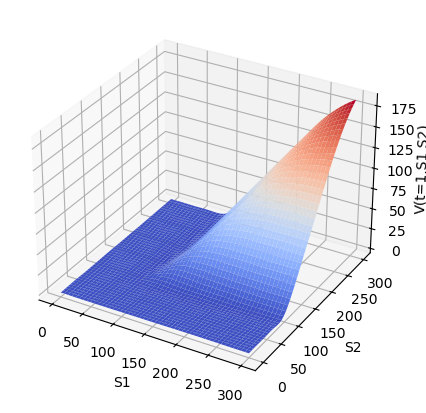

In [65]:
plot_surface(model,1,d=2)

In [69]:
import matplotlib.pyplot as plt

def plot_temporal_slices(model, S2_fixed=100.0, t_list=[0, T/3, 2*T/3, T], n_points=100):
    """
    Trace V(t, S1, S2_fixed) pour plusieurs t donnés.
    """
    S1_vals = np.linspace(S_low, S_high, n_points).reshape(-1, 1)
    S2_vals = np.full_like(S1_vals, S2_fixed)

    plt.figure(figsize=(6, 5))

    for t in t_list:
        t_vals = np.full_like(S1_vals, t)
        inputs = [tf.convert_to_tensor(t_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S1_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S2_vals, dtype=tf.float32)]

        with tf.device("/cpu:0"):
            preds = model(*inputs).numpy()

        plt.plot(S1_vals, preds, label=f"t = {t:.2f}")

    plt.xlabel(r"$S_1$")
    plt.ylabel(r"$V(t, S_1, S_2 = %.1f)$" % S2_fixed)
    plt.legend()
    plt.grid(True)
    plt.savefig("CH2_slices_2405.png", dpi=300)
    plt.show()

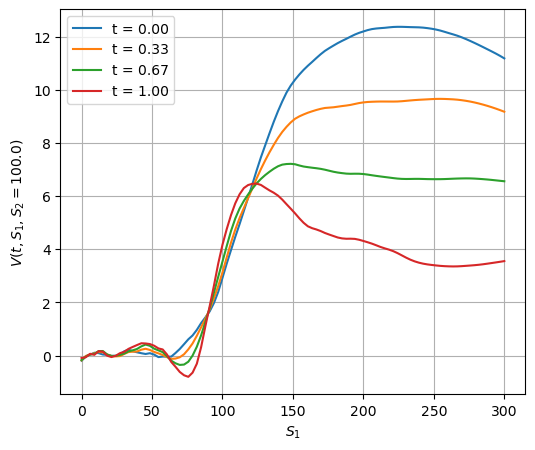

In [71]:
plot_temporal_slices(model, S2_fixed=100)

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_contour_solution(model, t_fixed=1.0, n_grid=100):
    """
    Trace une heatmap 2D de la solution V(t, S1, S2) à temps fixé (par défaut maturité t=1).
    """
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_vals = t_fixed * np.ones_like(S1_grid)

    # Préparation des inputs
    t_input = tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    # Prédiction
    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_grid, n_grid)

    # Affichage
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(S1_grid, S2_grid, V_pred, levels=50, cmap="coolwarm")
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    #plt.title(f"Option value at t = {t_fixed}")
    plt.colorbar(contour)
    plt.savefig("CH2_2Dmap_2405bis.png", dpi=300)
    plt.tight_layout()
    plt.show()

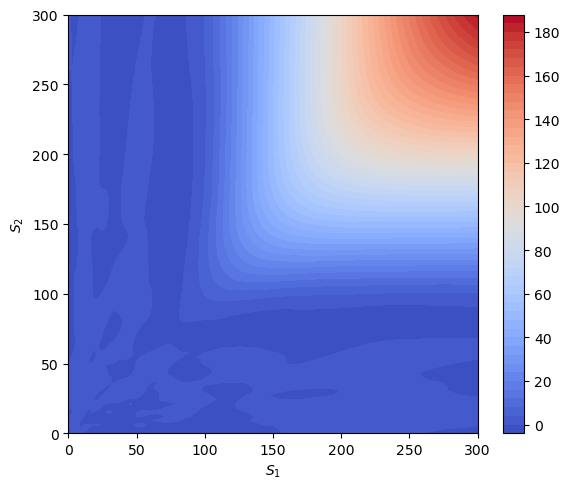

In [77]:
plot_contour_solution(model, t_fixed=1)

In [79]:
def plot_surface_time_vs_S1(model, S2_fixed=100.0, n_points=100):
    """
    Trace V(t, S1, S2_fixed) en surface 3D (t sur x, S1 sur y, V sur z)
    """
    t_vals = np.linspace(t_low, T, n_points)
    S1_vals = np.linspace(S_low, S_high, n_points)

    T_grid, S1_grid = np.meshgrid(t_vals, S1_vals)
    S2_grid = S2_fixed * np.ones_like(T_grid)

    t_input = tf.convert_to_tensor(T_grid.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_points, n_points)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(T_grid, S1_grid, V_pred, cmap="coolwarm", edgecolor="none")
    ax.set_xlabel("t")
    ax.set_ylabel("$S_1$")
    ax.set_zlabel(f"$V(t, S_1, S_2 = {S2_fixed})$",labelpad=1)
    #ax.set_title("Surface plot of option value over time and $S_1$")
    plt.savefig("CH2_surface_S2fixed_2405.png", dpi=300)
    plt.tight_layout()
    plt.show()

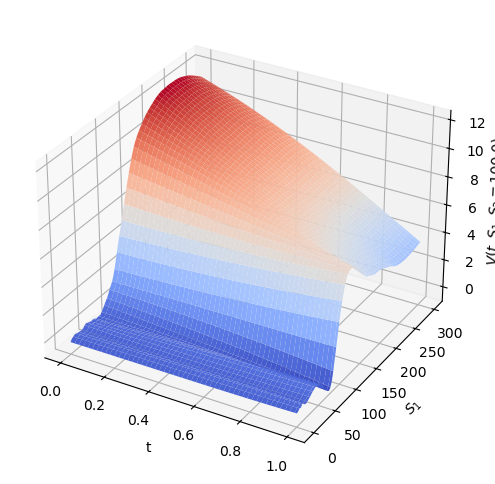

In [81]:
plot_surface_time_vs_S1(model, S2_fixed=100.0)

In [91]:
def monte_carlo_max_call(S1, S2, t, K, T, r, sigma1, sigma2, rho=0.0, n_paths=1000000, seed=42):
    np.random.seed(seed)
    dt = T - t
    S1 = np.array(S1).reshape(-1, 1)
    S2 = np.array(S2).reshape(-1, 1)
    n_samples = S1.shape[0]
    Z1 = np.random.randn(n_samples, n_paths)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(n_samples, n_paths)
    S1_T = S1 * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    S2_T = S2 * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * Z2)
    payoff = np.maximum(np.minimum(S1_T, S2_T) - K, 0)
    return np.exp(-r * dt) * np.mean(payoff, axis=1)

# Grille S1/S2
n_grid = 50
S1_vals = np.linspace(S_low, S_high, n_grid)
S2_vals = np.linspace(S_low, S_high, n_grid)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
S1_flat = S1_grid.flatten()
S2_flat = S2_grid.flatten()

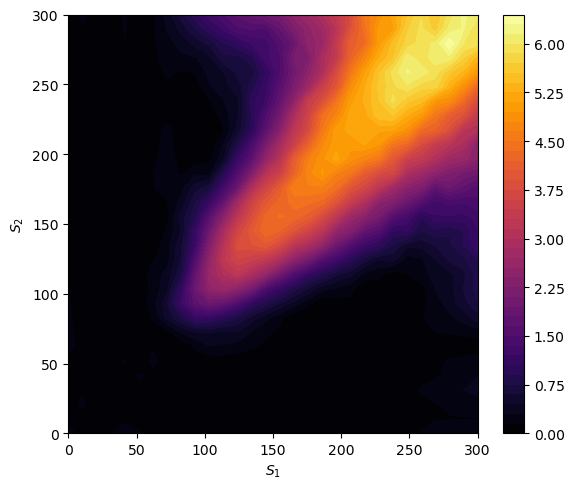

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.297097,0.012787,0.130910,0.143865,0.215008,0.166261,0.072090,0.044551,0.057000,0.039920,...,0.119617,0.109744,0.098741,0.099661,0.120638,0.155629,0.191301,0.222502,0.254273,0.294009
10.34,0.001182,0.032783,0.138049,0.096395,0.123789,0.029820,0.044859,0.031491,0.027272,0.002555,...,0.070522,0.067294,0.064721,0.076048,0.103042,0.129701,0.142870,0.144137,0.142534,0.145366
20.69,0.046171,0.185007,0.036438,0.100007,0.060287,0.013560,0.028069,0.022901,0.002140,0.052011,...,0.084495,0.080416,0.084002,0.088652,0.099131,0.121656,0.145345,0.165349,0.187498,0.217735
31.03,0.034431,0.127486,0.091420,0.019495,0.072051,0.085794,0.041521,0.010901,0.092791,0.085306,...,0.039224,0.051580,0.060158,0.074311,0.111778,0.158521,0.196257,0.240431,0.298368,0.373814
41.38,0.047226,0.040234,0.090384,0.017101,0.020137,0.182219,0.090264,0.038891,0.000211,0.047880,...,0.087033,0.110149,0.121715,0.125716,0.123527,0.120303,0.133825,0.171857,0.225074,0.292935
51.72,0.118533,0.081174,0.091456,0.042492,0.167885,0.010601,0.193745,0.044950,0.084186,0.119091,...,0.017675,0.018745,0.012680,0.028775,0.049951,0.076293,0.116595,0.161917,0.204791,0.239507
62.07,0.188234,0.106389,0.003018,0.083795,0.073878,0.073284,0.133999,0.093174,0.024911,0.158765,...,0.073532,0.050023,0.047201,0.062345,0.062853,0.045519,0.020443,0.001720,0.042197,0.065229
72.41,0.202871,0.050604,0.063092,0.082436,0.062019,0.011944,0.062448,0.091575,0.308034,0.439663,...,0.092818,0.123427,0.097491,0.111988,0.120942,0.123567,0.149082,0.173690,0.181077,0.221249
82.76,0.194813,0.003441,0.115086,0.033859,0.049669,0.015085,0.169025,0.494252,0.764915,1.106871,...,0.061872,0.005656,0.017845,0.026695,0.079497,0.133062,0.238260,0.252096,0.372014,0.537280
93.10,0.167604,0.050967,0.047558,0.127815,0.088056,0.059542,0.230082,0.581217,1.180886,1.701930,...,0.104270,0.069424,0.017998,0.052820,0.001103,0.105658,0.212261,0.382228,0.529539,0.733136


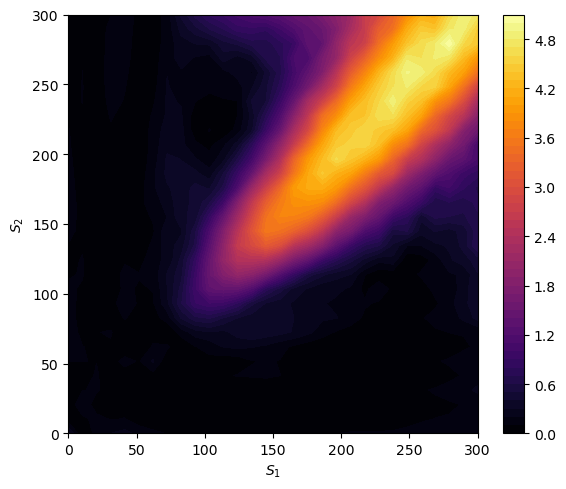

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.324159,0.005014,0.134688,0.199836,0.232797,0.173443,0.117297,0.097023,0.083200,0.049384,...,0.107210,0.109159,0.109104,0.111861,0.119741,0.129368,0.136952,0.145403,0.162448,0.193862
10.34,0.015501,0.071294,0.137685,0.091421,0.103814,0.034573,0.044318,0.010338,0.001475,0.002196,...,0.039032,0.036516,0.039641,0.052626,0.072766,0.091017,0.101518,0.105607,0.107422,0.109760
20.69,0.008705,0.195023,0.029664,0.072276,0.054695,0.013626,0.011476,0.007580,0.010708,0.001359,...,0.065286,0.069839,0.071575,0.069029,0.069833,0.075556,0.081142,0.088909,0.103987,0.128512
31.03,0.019748,0.093767,0.118169,0.042593,0.020422,0.049603,0.023968,0.021665,0.055172,0.007004,...,0.005941,0.002400,0.018178,0.037535,0.064198,0.089418,0.109358,0.134466,0.170071,0.220299
41.38,0.014057,0.038281,0.114969,0.019239,0.035597,0.067279,0.061998,0.090391,0.000930,0.004125,...,0.039536,0.047477,0.044764,0.034511,0.027822,0.030897,0.048753,0.075145,0.108777,0.154224
51.72,0.099245,0.101619,0.097181,0.040495,0.142290,0.089216,0.210801,0.024669,0.001688,0.043971,...,0.032557,0.014001,0.008728,0.028973,0.051317,0.071438,0.091141,0.112857,0.142025,0.176310
62.07,0.171812,0.102681,0.081578,0.083405,0.000590,0.039809,0.108402,0.117810,0.014657,0.097246,...,0.001188,0.000253,0.006187,0.018211,0.017086,0.004214,0.023308,0.048136,0.084123,0.116342
72.41,0.175377,0.063053,0.094620,0.112218,0.003090,0.070767,0.066103,0.009967,0.143509,0.249005,...,0.054916,0.064161,0.059413,0.065419,0.080035,0.076583,0.084973,0.101624,0.106303,0.116341
82.76,0.171901,0.033976,0.068016,0.026219,0.112342,0.024513,0.057662,0.144662,0.411665,0.574041,...,0.152551,0.081784,0.058396,0.049265,0.067945,0.088727,0.135542,0.144371,0.223245,0.336166
93.10,0.153907,0.053567,0.023859,0.041613,0.184414,0.080314,0.086501,0.275601,0.586970,0.889306,...,0.150915,0.112419,0.085076,0.041864,0.044876,0.068405,0.080358,0.170957,0.258646,0.392855


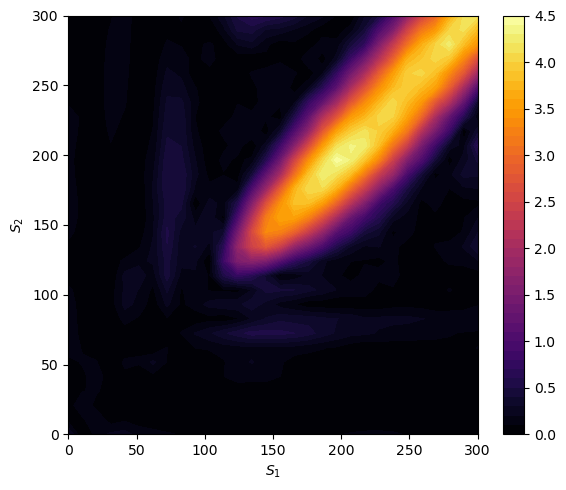

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.313436,0.003734,0.132582,0.221330,0.243550,0.162371,0.145833,0.114652,0.092324,0.061967,...,0.109210,0.119714,0.120385,0.111167,0.095078,0.075719,0.057373,0.047064,0.052096,0.075380
10.34,0.064337,0.077984,0.188363,0.046799,0.083927,0.046954,0.013293,0.014215,0.000384,0.000002,...,0.031538,0.032789,0.038248,0.048167,0.060903,0.073708,0.083927,0.089673,0.089660,0.083909
20.69,0.046704,0.181853,0.062235,0.028909,0.081239,0.051356,0.044378,0.036670,0.001964,0.010692,...,0.059308,0.058933,0.060946,0.060844,0.058414,0.053863,0.049632,0.049612,0.054717,0.064504
31.03,0.083366,0.096682,0.110636,0.061434,0.081162,0.059842,0.012916,0.053559,0.062413,0.000400,...,0.003984,0.014287,0.041723,0.056412,0.061576,0.062237,0.059754,0.060554,0.070403,0.090945
41.38,0.028931,0.073760,0.153193,0.034856,0.083019,0.025813,0.067273,0.099486,0.018660,0.045051,...,0.029440,0.029654,0.025516,0.015155,0.003306,0.008213,0.015176,0.011407,0.001991,0.021981
51.72,0.059976,0.111700,0.103299,0.030394,0.115151,0.114400,0.222553,0.093062,0.015243,0.042061,...,0.056010,0.050425,0.059879,0.078595,0.088988,0.089028,0.083311,0.077046,0.076162,0.081928
62.07,0.164664,0.090843,0.073213,0.080042,0.054626,0.077248,0.003329,0.103767,0.024771,0.101593,...,0.039879,0.006099,0.034001,0.045975,0.053735,0.062916,0.075952,0.082566,0.087405,0.101342
72.41,0.161532,0.066555,0.097024,0.042485,0.047962,0.038100,0.069417,0.020358,0.105132,0.208977,...,0.235565,0.221379,0.191577,0.158224,0.143653,0.131838,0.116938,0.105541,0.093158,0.079074
82.76,0.156960,0.061946,0.097660,0.023296,0.135747,0.084819,0.048498,0.086483,0.060632,0.032537,...,0.272909,0.216272,0.220844,0.229977,0.228995,0.204452,0.185910,0.169470,0.174471,0.200243
93.10,0.141131,0.061060,0.032644,0.044349,0.234731,0.171333,0.037190,0.222436,0.077202,0.149072,...,0.023994,0.025322,0.033845,0.056999,0.063691,0.056736,0.024415,0.040180,0.049517,0.089018


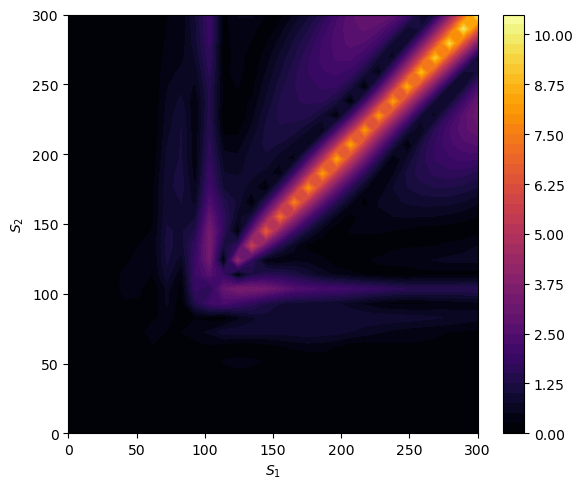

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.280483,0.033997,0.108024,0.153439,0.198774,0.121637,0.164333,0.126368,0.126142,0.112622,...,0.145487,0.150761,0.135518,0.101959,0.056748,0.008576,0.033768,0.061863,0.069901,0.057592
10.34,0.125761,0.101674,0.250302,0.026324,0.100175,0.049556,0.028389,0.027517,0.010986,0.033525,...,0.045483,0.051194,0.055532,0.060568,0.068542,0.080537,0.093255,0.099545,0.092819,0.071953
20.69,0.056363,0.178395,0.128703,0.042024,0.031131,0.070589,0.138952,0.054232,0.059838,0.085693,...,0.032919,0.026399,0.039164,0.050090,0.050740,0.047498,0.047248,0.048209,0.044940,0.036569
31.03,0.114478,0.096966,0.063247,0.113827,0.246925,0.156948,0.015874,0.057251,0.118820,0.033786,...,0.035926,0.081423,0.117346,0.110507,0.082554,0.051951,0.021035,0.004100,0.019799,0.030465
41.38,0.050000,0.136366,0.223481,0.030532,0.092281,0.100650,0.105184,0.004117,0.083318,0.093729,...,0.060068,0.061940,0.064201,0.063188,0.042441,0.008957,0.066355,0.092924,0.104225,0.114872
51.72,0.020969,0.112215,0.068724,0.023192,0.037007,0.045667,0.225466,0.175542,0.110845,0.058564,...,0.149264,0.160285,0.179762,0.190433,0.174882,0.142535,0.105577,0.059710,0.007809,0.039911
62.07,0.183098,0.098346,0.019644,0.082208,0.097930,0.188286,0.192135,0.070441,0.123521,0.109650,...,0.072903,0.062005,0.144610,0.184125,0.202827,0.205901,0.194662,0.162075,0.121729,0.097567
72.41,0.139047,0.039931,0.128564,0.138037,0.105852,0.091948,0.461428,0.214844,0.245204,0.434063,...,0.741777,0.627502,0.513770,0.426544,0.355275,0.314423,0.281634,0.245245,0.213965,0.187251
82.76,0.112320,0.053713,0.158334,0.083647,0.079923,0.167616,0.177997,0.380693,0.055901,0.226550,...,0.954891,0.948773,0.933158,0.927448,0.882526,0.834258,0.786666,0.720812,0.646817,0.574815
93.10,0.088827,0.051571,0.031447,0.125910,0.212569,0.223502,0.042983,0.536062,0.061348,1.323088,...,0.627223,0.443559,0.282016,0.189397,0.168417,0.203447,0.257264,0.310983,0.366397,0.413584


In [107]:
import pandas as pd

for i, t_fixed in enumerate([0.0, T/3, 2*T/3, T]):
    # Monte Carlo
    V_MC_flat = monte_carlo_max_call(S1_flat, S2_flat, t_fixed, K, T, r, sigma1, sigma2, rho, 100000)

    # PINN
    t_tensor = tf.convert_to_tensor(np.full_like(S1_flat, t_fixed).reshape(-1, 1), dtype=tf.float32)
    S1_tensor = tf.convert_to_tensor(S1_flat.reshape(-1, 1), dtype=tf.float32)
    S2_tensor = tf.convert_to_tensor(S2_flat.reshape(-1, 1), dtype=tf.float32)
    V_PINN_flat = model(t_tensor, S1_tensor, S2_tensor).numpy().flatten()

    abs_error = np.abs(V_MC_flat - V_PINN_flat).reshape(n_grid, n_grid)

    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.contourf(S1_grid, S2_grid, abs_error, levels=50, cmap="inferno")
    plt.colorbar()
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    plt.tight_layout()
    plt.savefig(f"CH2_image_WO_ERROR_{8+i}4.png", dpi=300)
    plt.show()

    # Tableau d'erreur
    df_error = pd.DataFrame(abs_error, index=np.round(S2_vals, 2), columns=np.round(S1_vals, 2))
    display(df_error)

    # Sauvegarde Excel
    df_error.to_excel(f"CH2_error_table_WO_{8+i}4.xlsx")